In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/salamander/fastai')

from timeit import default_timer as timer
from fastai.imports import *
from fastai.torch_imports import *
from fastai.learner import *
from fastai.column_data import *

In [3]:
class RLinear(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0, norm=True):
        super(RLinear, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.dropout = dropout
        self.norm = norm
    def forward(self, x):
        x = self.fc(x)
        # if self.norm: x = self.bn(x)
        x = F.relu(x)
        # if self.dropout > 0: x = F.dropout(x, p=self.dropout, training=self.training)
        return x

In [4]:
class SLinear(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0, norm=True):
        super(SLinear, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.dropout = dropout
        self.norm = norm
        nn.init.normal(self.fc.weight, std=1/input_dim**.5)
        nn.init.constant(self.fc.bias, 0.)
    def forward(self, x):
        x = self.fc(x)
        if self.norm: x = F.selu(x)
        x = F.alpha_dropout(x, p=self.dropout, training=self.training)
        return x

In [5]:
class AbstractNet(nn.Module):
    def __init__(self, input_dim, output_dim, n_hidden_layers, hidden_dim, dropout=0.05):
        super(AbstractNet, self).__init__()
        self.input = self.Linear(input_dim, hidden_dim, dropout)
        self.n_hidden_layers = n_hidden_layers
        for i in range(self.n_hidden_layers): setattr(self, f'hidden_{i}', self.Linear(hidden_dim, hidden_dim, dropout))
        self.output = self.Linear(hidden_dim, output_dim, norm=False)
    def forward(self, x):
        x = self.input(x)
        for i in range(self.n_hidden_layers): x = getattr(self, f'hidden_{i}')(x)
        x = self.output(x)
        x = F.softmax(x)
        return x

class RNet(AbstractNet):
    Linear = RLinear

class SNet(AbstractNet):
    Linear = SLinear

In [6]:
class CatLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return F.cross_entropy

class CatModel(BasicModel):
    def get_layer_groups(self): return self.model

class CatDataset(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return [self.x[i], self.y[i]]

class CatModelData(ModelData):
    def __init__(self, path, val_x, val_y, trn_x, trn_y, batch_size):
        val_ds = CatDataset(val_x, val_y)
        trn_ds = CatDataset(trn_x, trn_y)
        val_dl = DataLoader(val_ds, batch_size, shuffle=True, num_workers=1)
        trn_dl = DataLoader(trn_ds, batch_size, shuffle=True, num_workers=1)
        super().__init__(path, val_dl, trn_dl)
    @classmethod
    def from_idxs(cls, path, val_idxs, x, y, batch_size):
        (val_x, trn_x), (val_y, trn_y) = split_by_idx(val_idxs, x, y)
        val_y = val_y[:, 0]
        trn_y = trn_y[:, 0]
        return cls(path, val_x, val_y, trn_x, trn_y, batch_size)

In [7]:
def get_learner(dataset, batch_size, Model, *args, **kwargs):
    x = pd.read_csv(f'data/{dataset}/{dataset}_py.dat', header=None)
    y = pd.read_csv(f'data/{dataset}/labels_py.dat', header=None)
    print(f"{len(x)} rows, {len(x.columns)} cols, {y[0].nunique()} unique labels in '{dataset}'\n")
    val_perc = 0.25
    val_idx = y.sample(int(len(y)*val_perc)).index
    data = CatModelData.from_idxs('results', val_idx, x.values, y.values, batch_size=batch_size)
    model = Model(len(x.columns), y[0].nunique(), *args, **kwargs)
    model = CatModel(to_gpu(model))
    learner = CatLearner(data, model)
    learner.half()
    return learner

In [8]:
l = get_learner('mushroom', 1024, RNet, 2, 128, 0.05)
l.fit(0.01, 4, cycle_len=1, cycle_mult=2, metrics=[accuracy])

8124 rows, 21 cols, 2 unique labels in 'mushroom'



epoch      trn_loss   val_loss   accuracy   
    0      0.690156   0.689314   0.522731  
    1      0.69004    0.688759   0.524536  
    2      0.68983    0.688489   0.526013  
    3      0.689616   0.68743    0.526998  
    4      0.689265   0.686469   0.529296  
    5      0.688874   0.685913   0.531594  
    6      0.688527   0.685777   0.53225   
    7      0.688202   0.684206   0.542918  
    8      0.687753   0.682663   0.559166  
    9      0.687217   0.68128    0.582636  
    10     0.686639   0.680149   0.605449  
    11     0.686054   0.679328   0.623338  
    12     0.685487   0.678832   0.637617  
    13     0.684965   0.678611   0.644018  
    14     0.684499   0.678564   0.645167  



[array([0.67856]), 0.6451665817585833]

In [9]:
l = get_learner('mushroom', 1024, SNet, 32, 128, 0.05)
l.fit(0.01, 5, cycle_len=1, cycle_mult=2, metrics=[accuracy])

8124 rows, 21 cols, 2 unique labels in 'mushroom'



epoch      trn_loss   val_loss   accuracy   
    0      0.727138   0.793082   0.443952  
    1      0.729695   0.73929    0.508781  
    2      0.730081   0.715259   0.536846  
    3      0.72887    0.635094   0.647628  
    4      0.7266     0.580525   0.741671  
    5      0.725041   0.558589   0.778434  
    6      0.724348   0.554214   0.785492  
    7      0.72448    0.522648   0.841622  
    8      0.721522   0.50827    0.863122  
    9      0.720603   0.500054   0.872477  
    10     0.717798   0.492703   0.876416  
    11     0.71547    0.486355   0.877564  
    12     0.713497   0.481114   0.879862  
    13     0.712241   0.478413   0.879862  
    14     0.711276   0.477807   0.879698  
    15     0.709585   0.454534   0.879698  
    16     0.707915   0.440133   0.883145  
    17     0.70421    0.432539   0.881832  
    18     0.699485   0.428929   0.884786  
    19     0.693287   0.427898   0.884293  
    20     0.685352   0.42583    0.887084  
    21     0.676068   0.423236 

[array([0.40974]), 0.903495815045607]

In [10]:
class BatchLinear(nn.Module):
    def __init__(self, n_towers, in_features, out_features):
        super(BatchLinear, self).__init__()
        self.n_towers = n_towers
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(n_towers, in_features, out_features))
        self.bias = nn.Parameter(torch.Tensor(n_towers, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        output = input.unsqueeze(2)
        output = torch.matmul(output, self.weight)
        output = output.squeeze(2)
        output += self.bias
        return output

    def extra_repr(self):
        return 'n_towers={} in_features={}, out_features={}'.format(
            self.n_towers, self.in_features, self.out_features
        )

In [11]:
class MLinear(nn.Module):
    def __init__(self, n_towers, tower_sz, dropout=0):
        super(MLinear, self).__init__()
        self.fc = BatchLinear(n_towers, tower_sz, tower_sz)
        self.dropout = dropout
        nn.init.normal(self.fc.weight, std=1/tower_sz**.5)
        nn.init.constant(self.fc.bias, 0.)
    def forward(self, x):
        x = self.fc(x)
        x = F.selu(x)
        x = F.alpha_dropout(x, p=self.dropout, training=self.training)
        return x

In [12]:
mean = 0
variance = 1
samples = 1000000

# vectors
a = np.random.normal(mean, variance, samples)
b = np.random.normal(mean, variance, samples)
c = np.random.normal(mean, variance, samples)

d = np.random.normal(mean, variance, samples)
e = np.random.normal(mean, variance, samples)
f = np.random.normal(mean, variance, samples)

# weights
weight_a = 2
weight_b = -1.2
weight_c = 0.1

noise = (d * weight_a) + (e * weight_b) + (f * weight_c)
result = (a * weight_a) + (b * weight_b) + (c * weight_c)
result *= np.flip(result, 0) / (weight_a**2 + weight_b**2 + weight_c**2)
print(np.mean(result), np.var(result))

0.0009307328738525794 0.998965505823315


In [13]:
class MCombineAverage(nn.Module):
    def __init__(self, out_dim, n_towers, tower_sz, serial_factor=1):
        super(MCombine, self).__init__()
        self.out_dim = out_dim
        self.n_towers = n_towers
        self.tower_sz = tower_sz
        assert (out_dim / tower_sz).is_integer(), f'out_dim ({out_dim}) must be divisible by tower_sz ({tower_sz})'
        self.n_repeat = int(out_dim / tower_sz)
        self.batch_sz = int(max(self.n_repeat / serial_factor, n_towers / tower_sz))
        self.weights = nn.Parameter(torch.Tensor(self.n_repeat, self.n_towers, 1))
        nn.init.normal(self.weights, std=1.)
    def flip(tensor):
        inv_idx = Variable(torch.arange(tensor.size(0)-1, -1, -1).long().cuda())
        inv_tensor = tensor.index_select(0, inv_idx)
        inv_tensor = tensor[inv_idx]
        return inv_tensor
    def forward(self, x):
        x = x.unsqueeze(1)
        tmp = []
        for start in range(0, self.n_repeat, self.batch_sz):
            end = min(start + self.batch_sz, self.n_repeat)
            sz = end - start
            xi = x.repeat(1, sz, 1, 1)
            xi = xi.mul(self.weights[start:end])
            xim = xi.mean(2)
            tmp.append(xim)
            del xi # free memory
        x = torch.stack(tmp, 1)
        x_flipped = self.flip(x) # flip batch to get "random" distribution samples
        x = x * (x_flipped / (self.weights**2).sum()) # normalize variance
        x = x.view(-1, self.out_dim)
        return x

In [14]:
class MCombineLinear(nn.Module):
    def __init__(self, out_dim, n_towers, tower_sz, dropout=0):
        super(MCombineLinear, self).__init__()
        assert (out_dim / tower_sz).is_integer(), f'out_dim ({out_dim}) must be divisible by tower_sz ({tower_sz})'
        self.out_dim = out_dim
        self.n_towers = n_towers
        self.tower_sz = tower_sz
        self.fc = BatchLinear(tower_sz, n_towers, int(out_dim / tower_sz))
        self.dropout = dropout
        nn.init.normal(self.fc.weight, std=1/tower_sz**.5)
        nn.init.constant(self.fc.bias, 0.)
    def forward(self, x):
        x = x.view(-1, self.tower_sz, self.n_towers)
        x = self.fc(x)
        x = x.view(-1, self.out_dim)
        x = F.selu(x)
        x = F.alpha_dropout(x, p=self.dropout, training=self.training)
        return x

In [15]:
class MReshape(nn.Module):
    def __init__(self, in_dim, n_towers, tower_sz):
        super(MReshape, self).__init__()
        self.in_dim = in_dim
        self.n_towers = n_towers
        self.tower_sz = tower_sz
        self.n_repeat = int((n_towers * tower_sz) / in_dim)
        assert ((n_towers * tower_sz) / in_dim).is_integer(), \
            f'(n_towers [{n_towers}] * tower_sz [{tower_sz}]) [{n_towers * tower_sz}] must be divisible by in_dim ({in_dim})'
    def forward(self, x):
        x = x.view(x.shape[0], -1, self.tower_sz)
        x = x.repeat(1, self.n_repeat, 1)
        return x

In [16]:
class AbstractMBlock(nn.Module):
    def __init__(self, in_dim, out_dim, n_towers, tower_sz, n_layers, dropout=0):
        super(AbstractMBlock, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.n_towers = n_towers
        self.tower_sz = tower_sz
        self.n_layers = n_layers
        self.input = MReshape(in_dim, n_towers, tower_sz)
        for i in range(self.n_layers): setattr(self, f'layer_{i}', MLinear(n_towers, tower_sz, dropout))
        self.combine = self.Combine(out_dim, n_towers, tower_sz, dropout=dropout)
        self.output = SLinear(out_dim, out_dim)
    def forward(self, x):
        x = self.input(x)
        for i in range(self.n_layers): x = getattr(self, f'layer_{i}')(x)
        x = self.combine(x)
        x = self.output(x)
        return x

class MBlockAverage(AbstractMBlock):
    Combine = MCombineAverage

class MBlockLinear(AbstractMBlock):
    Combine = MCombineLinear

In [17]:
class MNet(nn.Module):
    # blocks = [(in_dim, n_towers, tower_sz, n_layers), ...]
    def __init__(self, in_dim, out_dim, blocks, dropout=0.05):
        super(MNet, self).__init__()
        self.n_blocks = len(blocks)
        self.input = SLinear(in_dim, blocks[0][0], dropout)
        for i, block in enumerate(blocks):
            nxt_dim = blocks[i + 1][0] if i < len(blocks) - 1 else block[0]
            in_dim, n_towers, tower_sz, n_layers = block
            setattr(self, f'block_{i}', MBlockLinear(in_dim, nxt_dim, n_towers, tower_sz, n_layers, dropout))
        self.output = SLinear(blocks[len(blocks) - 1][0], out_dim, norm=False)
    def forward(self, x):
        x = self.input(x)
        for i in range(self.n_blocks): x = getattr(self, f'block_{i}')(x)
        x = self.output(x)
        return x

In [18]:
dataset = 'mushroom'
l = get_learner(dataset, 512, MNet, [(256, 256, 16, 6), (128, 128, 16, 6), (64, 64, 16, 6)], 0.)
l.fit(0.01, 4, cycle_len=1, cycle_mult=2, metrics=[accuracy])

8124 rows, 21 cols, 2 unique labels in 'mushroom'



epoch      trn_loss   val_loss   accuracy   
    0      1.023263   0.527501   0.756606  
    1      0.634809   0.160713   0.936156  
    2      0.449255   0.132253   0.94666   
    3      0.342099   0.062527   0.973904  
    4      0.26981    0.039395   0.985229  
    5      0.218879   0.031462   0.989004  
    6      0.182067   0.030238   0.989496  
    7      0.154149   0.020696   0.993107  
    8      0.131839   0.015189   0.995569  
    9      0.113824   0.012262   0.996389  
    10     0.099123   0.010767   0.996882  
    11     0.086961   0.010072   0.997046  
    12     0.076775   0.009779   0.997046  
    13     0.068157   0.009689   0.997046  
    14     0.060795   0.009676   0.997046  



[array([0.00968]), 0.9970457902511078]

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [50]:
def get_tox21_learner(batch_size, Model, opt_fn, *args, **kwargs):
    y_trn = pd.read_csv('tox21/tox21_labels_train.csv.gz', index_col=0, compression="gzip")
    y_val = pd.read_csv('tox21/tox21_labels_test.csv.gz', index_col=0, compression="gzip")
    y_trn.columns = range(y_val.shape[1])
    y_trn = (y_trn == 1).idxmax(1).values
    y_val.columns = range(y_val.shape[1])
    y_val = (y_val == 1).idxmax(1).values

    x_trn = pd.read_csv('tox21/tox21_dense_train.csv.gz', index_col=0, compression="gzip").values
    x_val = pd.read_csv('tox21/tox21_dense_test.csv.gz', index_col=0, compression="gzip").values
    scaler = StandardScaler().fit(np.concatenate((x_trn, x_val), axis=0))
    x_trn = scaler.transform(x_trn).astype(np.float64)
    x_val = scaler.transform(x_val).astype(np.float64)

    print(f"{x_trn.shape[0]} rows, {x_trn.shape[1]} cols, {len(np.unique(y_trn))} unique labels in 'tox21'\n")
    
    data = CatModelData('results', x_val, y_val, x_trn, y_trn, batch_size=batch_size)
    model = Model(x_trn.shape[1], len(np.unique(y_trn)), *args, **kwargs)
    model = CatModel(to_gpu(model))
    learner = CatLearner(data, model, opt_fn=opt_fn) #.half()
    return learner

In [51]:
def auc(preds, target):
    preds = preds.cpu().numpy()
    target = one_hot(target.cpu().numpy(), preds.shape[1])
    total = 0
    labels = 0
    for i in range(preds.shape[1]):
        if target[:,i].sum() == 0: continue
        labels += 1
        total += roc_auc_score(target[:,i], preds[:,i])
    return total / labels

12060 rows, 801 cols, 12 unique labels in 'tox21'



epoch      trn_loss   val_loss   
    0      4.665791   4.444328  
    1      4.406434   3.990287  


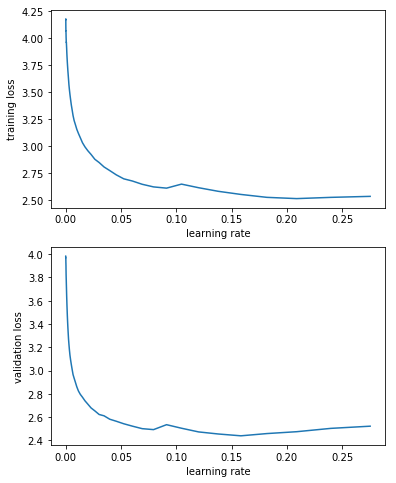

In [52]:
l = get_tox21_learner(512, MNet, optim.SGD, [(256, 256, 16, 8)], 0.05)
l.fit(0.001, 2)
l.lr_find2()
l.sched.plot()

In [53]:
l.fit(0.01, 5, cycle_len=1, cycle_mult=2, metrics=[accuracy, auc])

epoch      trn_loss   val_loss   accuracy   auc        
    0      4.05197    2.96072    0.210282   0.518532  
    1      3.521202   1.915465   0.605556   0.528368  
    2      2.998842   1.888555   0.63524    0.531405  
    3      2.731636   1.919747   0.662521   0.540717  
    4      2.538261   1.868643   0.684577   0.543776  
    5      2.419086   1.839129   0.684328   0.539926  
    6      2.327061   1.835271   0.684909   0.540142  
    7      2.248345   1.782355   0.687977   0.544289  
    8      2.216184   1.752898   0.697927   0.550237  
    9      2.146815   1.741966   0.700166   0.548003  
    10     2.074602   1.738955   0.697098   0.555234  
    11     2.029332   1.731724   0.700415   0.550325  
    12     1.996413   1.721574   0.70199    0.550095  
    13     1.961823   1.71998    0.701575   0.550342  
    14     1.939849   1.718933   0.701658   0.546995  
    15     1.923276   1.665127   0.697512   0.55235   
    16     1.915851   1.622955   0.703731   0.54584   
    17   

[array([1.61741]), 0.7043946935762814, 0.564118907891815]

In [25]:
sl = get_tox21_learner(1024, SNet, 8, 768, 0.05)
sl.fit(0.01, 7, cycle_len=1, cycle_mult=2, metrics=[accuracy, auc])

12060 rows, 801 cols, 12 unique labels in 'tox21'



epoch      trn_loss   val_loss   accuracy   auc        
    0      2.476115   2.469275   0.126866   0.488388  
    1      2.482309   2.469275   0.126866   0.483153  
    2      2.483103   2.429069   0.239801   0.490803  
    3      2.481933   2.429069   0.239801   0.496009  
    4      2.480413   2.344691   0.345771   0.516813  
    5      2.47457    2.344691   0.345771   0.516187  
    6      2.470638   2.250088   0.402736   0.560644  
    7      2.460819   2.250088   0.402736   0.557353  
    8      2.453887   2.194894   0.432587   0.580643  
    9      2.438378   2.194894   0.432587   0.574305  
    10     2.426282   2.166374   0.449005   0.580221  
    11     2.408      2.166374   0.449005   0.581582  
    12     2.392186   2.150902   0.456882   0.588451  
    13     2.374871   2.150902   0.456882   0.589361  
    14     2.359562   2.141676   0.462852   0.587921  
    15     2.343904   2.141676   0.462852   0.588416  
    16     2.329873   2.13513    0.467579   0.58948   
    17   

[array([2.1107]), 0.4893034829429133, 0.5979774795063751]